In [1]:
# Downloading Data
!gdown 1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV

Downloading...
From (original): https://drive.google.com/uc?id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV
From (redirected): https://drive.google.com/uc?id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV&confirm=t&uuid=dfe6d56f-efaa-4022-84fd-0ca2182264ac
To: /content/Fraud.csv
100% 494M/494M [00:09<00:00, 50.6MB/s]


In [2]:
# Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Data Collection & Preprocessing

In [3]:
df = pd.read_csv("/content/Fraud.csv")

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [6]:
df.shape

(6362620, 11)

In [7]:
# Dropping redundant information like temporal features and identifiers because these features don't add predictive value
df = df.drop(columns=['step', 'nameOrig', 'nameDest'])

In [8]:
df["isFlaggedFraud"].value_counts()

,count
isFlaggedFraud,
0,6362604
1,16


In [9]:
# Dropping 'isFlaggedFraud' as it is highly imbalanced and only flags transactions with amounts greater than 200,000.
df = df.drop(columns=['isFlaggedFraud'])

In [10]:
df["isFraud"].value_counts()

,count
isFraud,
0,6354407
1,8213


In [11]:
# Missing Values
df.isnull().sum()

,0
type,0
amount,0
oldbalanceOrg,0
newbalanceOrig,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


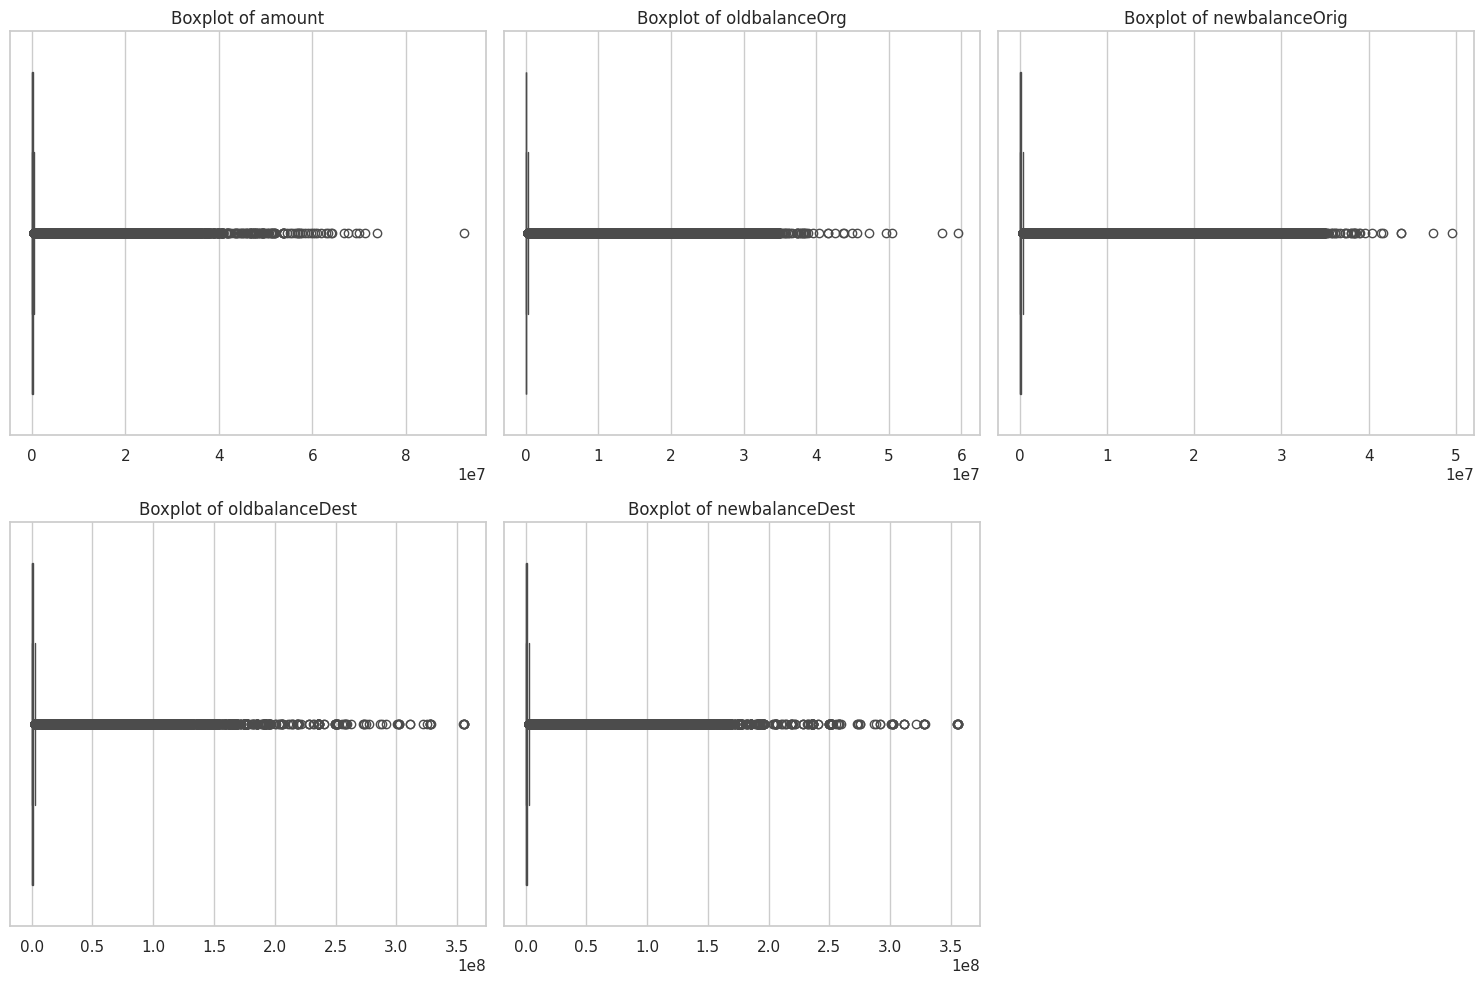

In [12]:
# Boxplot for finding Outliers
# Setting plot style for all the plots
sns.set(style="whitegrid")

# Select numerical features for boxplots
features_for_boxplot = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(15, 10))

for i, column in enumerate(features_for_boxplot, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x=np.array(df[column]))  # Use NumPy for efficient operations
        plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

In [13]:
# Multi-Collinearity
# Select numeric columns
features_for_multicollinearity = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]

# Compute correlation
correlation = features_for_multicollinearity.corr()

<Axes: >

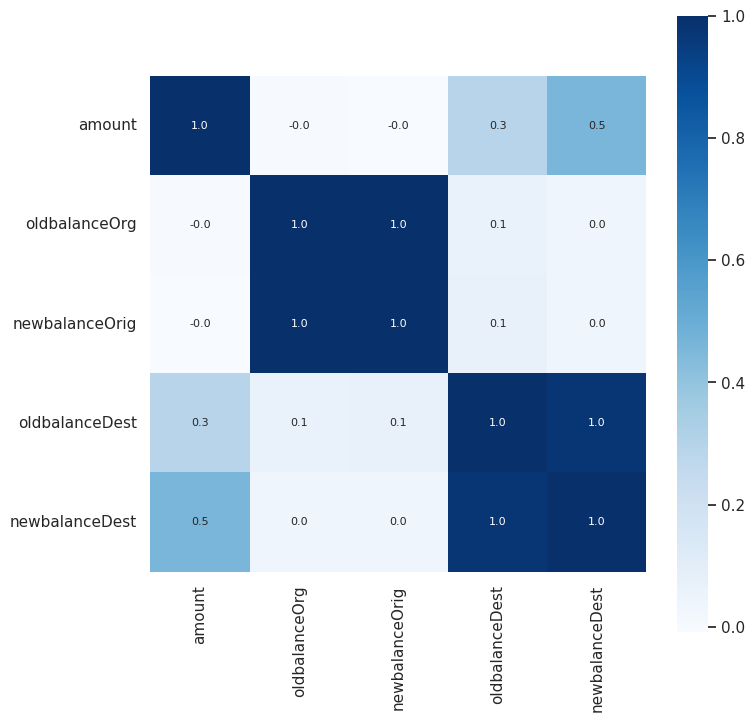

In [14]:
# Constructing a heatmap to understand the correlation
plt.figure(figsize=(8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size': 8}, cmap='Blues')

**Feature Redundancy**: Since the correlation between the old and new balances is perfect (1.0), keeping both does not provide additional information.

In [15]:
# Hence creating a new feature which retain the difference of new and old balances
df['balanceOrigDiff'] = df['newbalanceOrig']-df['oldbalanceOrg']
df['balanceDestDiff'] = df['newbalanceDest']-df['oldbalanceDest']

In [16]:
# Droping old and new balances to reduce redundancy.
df = df.drop(columns=['oldbalanceOrg', 'oldbalanceDest', 'newbalanceOrig', 'newbalanceDest'])

In [17]:
df.head()

,type,amount,isFraud,balanceOrigDiff,balanceDestDiff
0,PAYMENT,9839.64,0,-9839.64,0.0
1,PAYMENT,1864.28,0,-1864.28,0.0
2,TRANSFER,181.00,1,-181.00,0.0
3,CASH_OUT,181.00,1,-181.00,-21182.0
4,PAYMENT,11668.14,0,-11668.14,0.0


In [18]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [19]:
# Convert categorical column to numerical values
df.replace({'type' : {'PAYMENT': 0, 'TRANSFER': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'CASH_IN': 4}}, inplace=True)

<ipython-input-19-e55dc7d1bc8e>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'type' : {'PAYMENT': 0, 'TRANSFER': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'CASH_IN': 4}}, inplace=True)


In [20]:
df.head()

,type,amount,isFraud,balanceOrigDiff,balanceDestDiff
0,0,9839.64,0,-9839.64,0.0
1,0,1864.28,0,-1864.28,0.0
2,1,181.00,1,-181.00,0.0
3,2,181.00,1,-181.00,-21182.0
4,0,11668.14,0,-11668.14,0.0


In [21]:
df["isFraud"].value_counts()

,count
isFraud,
0,6354407
1,8213


In [22]:
# Separate majority and minority class
df_majority = df[df["isFraud"] == 0]
df_minority = df[df["isFraud"] == 1]

In [23]:
print(df_majority.shape)
print(df_minority.shape)

(6354407, 5)
(8213, 5)


In [24]:
# Downsample majority class to match minority count
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

In [25]:
df_majority_downsampled.shape

(8213, 5)

In [26]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [27]:
df_downsampled.shape

(16426, 5)

In [28]:
df_downsampled.head()

,type,amount,isFraud,balanceOrigDiff,balanceDestDiff
1777056,2,183806.32,0,-19391.00,183806.32
1350600,0,521.37,0,0.00,0.00
1991933,0,3478.18,0,-3478.18,0.00
5092368,0,1716.05,0,-1716.04,0.00
5066515,4,253129.93,0,253129.93,-253129.93


In [29]:
# Shuffle the final dataframe and reset the index
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [30]:
df_downsampled.head()

,type,amount,isFraud,balanceOrigDiff,balanceDestDiff
0,1,766151.45,1,-766151.45,0.00
1,1,31315.51,1,-31315.51,0.00
2,0,19043.02,0,-19043.02,0.00
3,0,11162.03,0,-11162.03,0.00
4,2,268851.80,0,-220431.00,268851.81


In [31]:
df_downsampled["isFraud"].value_counts()

,count
isFraud,
1,8213
0,8213


In [32]:
# Split features and target as X and y
X = df_downsampled.drop(columns=["isFraud"])
Y = df_downsampled["isFraud"]

In [33]:
print(X)

       type     amount  balanceOrigDiff  balanceDestDiff
0         1  766151.45       -766151.45             0.00
1         1   31315.51        -31315.51             0.00
2         0   19043.02        -19043.02             0.00
3         0   11162.03        -11162.03             0.00
4         2  268851.80       -220431.00        268851.81
...     ...        ...              ...              ...
16421     1  159106.12       -159106.12             0.00
16422     1  170038.31       -170038.31             0.00
16423     2    8369.07         -8369.07          8369.08
16424     4  262120.50        262120.50       -262120.50
16425     2  228416.57       -228416.57        228416.57

[16426 rows x 4 columns]


In [34]:
print(Y)

0        1
1        1
2        0
3        0
4        0
        ..
16421    1
16422    1
16423    0
16424    0
16425    1
Name: isFraud, Length: 16426, dtype: int64


In [35]:
# Splitting the data into training data and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

### Model Training

### Logistic Regression

In [36]:
# Initialize the Logistic Regression model
model = LogisticRegression()

In [37]:
# Train the model using scaled data
model.fit(X_train, Y_train)

LogisticRegression()

### Model Evaluation

In [38]:
# Accuracy on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [39]:
print('Accuracy on Training data: ', training_data_accuracy)

Accuracy on Training data:  0.9100456621004567


In [40]:
# Accuracy on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [41]:
print('Accuracy on Test data: ', test_data_accuracy)

Accuracy on Test data:  0.9038344491783323


**Observation**: We achieved an accuracy of over 90%. This means that if you use this model to predict 100 different transactions, it will correctly classify 90 of them. Typically, an accuracy score above 90% indicates that the model is performing well.

### Build a Predicative System

In [42]:
pd.DataFrame([df.iloc[6]])

,type,amount,isFraud,balanceOrigDiff,balanceDestDiff
6,0.0,7107.77,0.0,-7107.77,0.0


In [43]:
input_data = (0, 7107.77, -7107.77, 0.0)

input_data = pd.DataFrame([input_data], columns=X.columns)

prediction = model.predict(input_data)
print(prediction)

if (prediction[0] == 0):
    print("The transaction is not fraudulent.")
else:
    print("The transaction is fraudulent.")

[0]
The transaction is not fraudulent.


In [44]:
pd.DataFrame([df.iloc[969]])

,type,amount,isFraud,balanceOrigDiff,balanceDestDiff
969,1.0,1277212.77,1.0,-1277212.77,0.0


In [45]:
input_data = (1, 1277212.77, -1277212.77, 0.00)

input_data = pd.DataFrame([input_data], columns=X.columns)

prediction = model.predict(input_data)
print(prediction)

if (prediction[0] == 0):
    print("The transaction is not fraudulent.")
else:
    print("The transaction is fraudulent.")

[1]
The transaction is fraudulent.


### Questions:

Q1. Data cleaning including missing values, outliers and multi-collinearity.

Solution:

**Data Cleaning:**

- Removed unnecessary columns like step, nameOrig, and nameDest.
- Dropped 'isFlaggedFraud' because it was imbalanced and only flagged large transactions.
- Created a new column showing the difference between old and new balances, then removed the original balance columns because they were identical.

**Missing Values:**
- There are no missing values in the dataset.

**Outliers**
- Visualized outliers using Box-Plot.

**Multi-Collinearity:**
- Checked for highly related features using a correlation matrix.

<hr>

Q2. Describe your fraud detection model in elaboration.

Solution: Fraud detection model consists the Logistic regression model which is a statistical model used for binary classification tasks, where the goal is to predict one of two possible outcomes (e.g., "fraud" or "not fraud"). Despite the name, it's actually a classification model, not a regression model.

<hr>

Q3. How did you select variables to be included in the model?

Solution: I chose only the important numeric features and removed unnecessary ones like step, nameOrig, and nameDest. Since old and new balances were highly similar, I created a new feature showing the difference between them, which gives better insights. I also included the transaction type for more useful information and reduced memory usage by downcasting.

<hr>

Q4. Demonstrate the performance of the model by using best set of tools.

Solution: I used accuracy_score from sklearn.metrics to demonstrate the model's performance.

<hr>

Q5. What are the key factors that predict fraudulent customer?

Solution: Key factors that predict fraudulent customers include large transaction amounts, unusual transaction types (like CASH-OUT or TRANSFER), and sudden changes in account balances.

<hr>

Q6. Do these factors make sense? If yes, How? If not, How not?

Solution: Yes, these factors make sense because large amounts, unusual transaction types, and sudden balance changes are common indicators of fraud.

<hr>

Q7. What kind of prevention should be adopted while company update its infrastructure?

Solution: When updating infrastructure, companies should implement security measures, such as encryption and access control to prevent data breaches and fraud.

<hr>

Q8. Assuming these actions have been implemented, how would you determine if they work?

Solution: To see if these actions work, companies should check for security problems, test for weaknesses, watch for suspicious activity, and track any security issues over time.